In [25]:
from functools import reduce

from cycler import cycler
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from numbers import Number
import numpy as np
import pandas as pd
from scipy import stats as sstats
import wmfdata as wmf
from wmfdata.utils import pct_str, sig_figs
from wmfdata.charting import pct_fmt, M_fmt, comma_fmt

In [26]:
%matplotlib inline
wmf.charting.set_mpl_style()

In [27]:
FILE = "metrics/metrics.tsv"
metrics = pd.read_csv(FILE, sep="\t", parse_dates=["month"]).set_index("month")

graph_end = metrics.index[-1]
graph_start = graph_end - relativedelta(months = 47)

# Data transformation

In [28]:
# Transform content flows into content stocks
def stock_to_flow(arr):
    return arr[-1] - arr[0]

flow_cols = [
    "net_new_content_pages", 
    "net_new_Wikipedia_articles", 
    "net_new_Commons_content_pages", 
    "net_new_Wikidata_entities"
]
stock_cols = [
    "content_pages", 
    "Wikipedia_articles", 
    "Commons_content_pages",
    "Wikidata_entities"
]

name_map = {flow_cols[i]: stock_cols[i] for i in range(len(stock_cols))}

stock_metrics = metrics[flow_cols].cumsum().rename(name_map, axis=1)

metrics = pd.concat([metrics, stock_metrics], axis=1)

# Show results
metrics.tail()

,active_editors,global_south_active_editors,global_south_edits,global_south_new_editor_retention,global_south_nonbot_edits,mobile-heavy_wiki_active_editors,mobile-heavy_wiki_edits,mobile-heavy_wiki_new_editor_retention,mobile-heavy_wiki_nonbot_edits,mobile_edits,...,other_nonbot_edits,returning_active_editors,revert_rate,total_edits,uploads,wikidata_edits,content_pages,Wikipedia_articles,Commons_content_pages,Wikidata_entities
month,,,,,,,,,,,,,,,,,,,,,
2019-02-01,82554.0,19743.0,2241877.0,0.043472,2241875.0,3901.0,966696.0,0.045479,438437.0,1254935.0,...,10952758.0,66219.0,0.073758,44135189.0,531456.0,22667003.0,202528529.0,49968103.0,52635804.0,55245150.0
2019-03-01,87711.0,21679.0,2294512.0,0.045774,2294512.0,4252.0,996968.0,0.043950,465084.0,1379133.0,...,11748062.0,69973.0,0.063090,49434627.0,542547.0,28490299.0,204116333.0,50184360.0,53146527.0,55888825.0
2019-04-01,84358.0,19941.0,2053568.0,0.040104,2052287.0,3996.0,1412904.0,0.043767,414992.0,1356454.0,...,10955991.0,68823.0,0.055778,51252861.0,616226.0,30126989.0,205898446.0,50452614.0,53730588.0,56606245.0
2019-05-01,90211.0,20841.0,2273855.0,0.042966,2272975.0,4195.0,1384712.0,0.049625,460884.0,1493057.0,...,11728361.0,70888.0,0.059398,46847183.0,702372.0,23578489.0,207876625.0,50642120.0,54398055.0,57380606.0
2019-06-01,83541.0,20093.0,2090806.0,0.058605,2090322.0,4270.0,1262220.0,0.048544,452430.0,1461766.0,...,10591175.0,66471.0,0.055568,40171410.0,549546.0,18588097.0,209682899.0,50855973.0,54892902.0,58020132.0


# Report

In [29]:
report_order = [
    'content_pages', 
        'Wikipedia_articles',
        'Commons_content_pages', 
        'Wikidata_entities',
    'net_new_content_pages',
        'net_new_Wikipedia_articles',
        'net_new_Commons_content_pages',
        'net_new_Wikidata_entities',
    'active_editors',
        'new_active_editors',
        'returning_active_editors',
    'new_editor_retention',
    'revert_rate',
    'total_edits',
        'mobile_edits',
        'wikidata_edits',
        'uploads',
        'other_nonbot_edits',
    # Global South countries
    'global_south_active_editors',
    'global_south_new_editor_retention',
    'global_south_edits',
    'global_south_nonbot_edits',
    # Mobile-heavy wikis
    'mobile-heavy_wiki_active_editors',
    'mobile-heavy_wiki_new_editor_retention',
    'mobile-heavy_wiki_edits',
    'mobile-heavy_wiki_nonbot_edits'
]

In [30]:
def fmt_num(x):
    if isinstance(x, Number) and not pd.isnull(x):
        x = sig_figs(x, 3)
        
        if x < 5:
            return pct_str(x)
        else:
            return "{:,.0f}".format(x)
    else:
        return x

def calc_rpt(ser):   
    cur = ser[-1]
    
    try:
        yr_prev = ser[-13]
        yoy_change = (cur / yr_prev) - 1
    except IndexError:
        yoy_change = None
        
    try:
        cagr = (ser[-1] / ser[-48])**(1/4) - 1
    except IndexError:
        cagr = None
        
    
    res = [cur, yoy_change, cagr]
    return pd.Series(
        [fmt_num(n) for n in res],
        index=["value", "yoy_change", "4_yr_cagr"]
    )

In [31]:
(
    metrics
    .apply(calc_rpt)
    .transpose()
    .reindex(report_order)
    .fillna("—")
)

,value,yoy_change,4_yr_cagr
content_pages,"210,000,000",11.9%,17.3%
Wikipedia_articles,"50,900,000",5.1%,9.3%
Commons_content_pages,"54,900,000",14.9%,19.5%
Wikidata_entities,"58,000,000",18.4%,34.6%
net_new_content_pages,"1,810,000",10.3%,14.1%
net_new_Wikipedia_articles,"214,000",20.7%,-0.6%
net_new_Commons_content_pages,"495,000",-13.1%,0.5%
net_new_Wikidata_entities,"640,000",10.7%,62.8%
active_editors,"83,500",6.4%,0.9%
new_active_editors,"17,100",13.7%,-1.7%


# Graphs

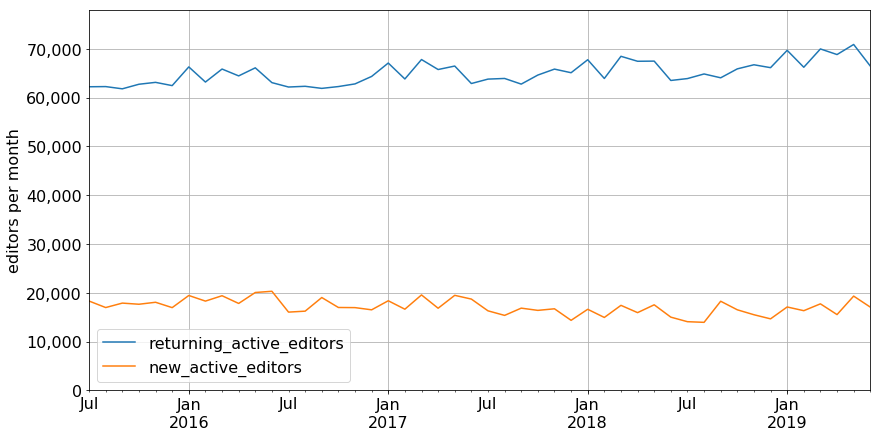

In [32]:
ax = metrics[["returning_active_editors", "new_active_editors"]][graph_start:graph_end].plot()
plt.gca().yaxis.set_major_formatter(comma_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("editors per month");

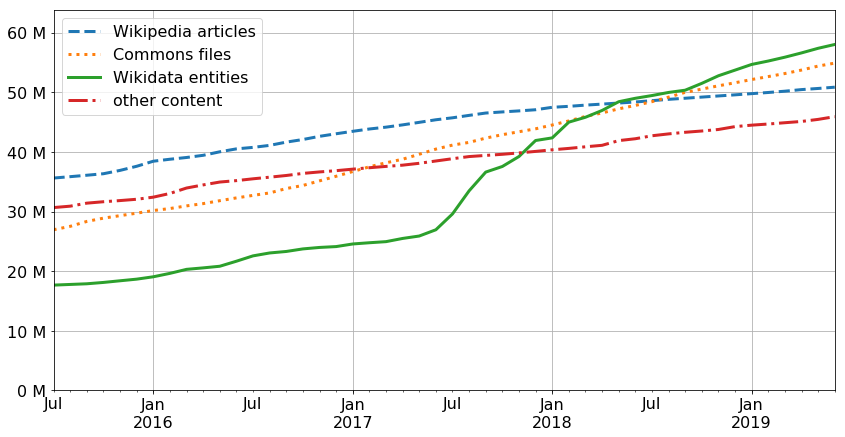

In [33]:
custom_cyc = cycler('color', ['r', 'g', 'b', 'y']) + cycler('linestyle', ['-', '--', ':', '-.'])
content_types = metrics[["Wikipedia_articles", "Commons_content_pages", "Wikidata_entities"]]
content_ser = [tup[1] for tup in content_types.iteritems()]

other_content = reduce(lambda x, y: x - y, content_ser, metrics["content_pages"]).rename("other_content")
content = pd.concat(
    [content_types, other_content], 
    axis=1
).rename(
    columns=lambda name: name.replace("_", " ")
).rename(
    columns={"Commons content pages": "Commons files"}
)

ax.set_prop_cycle(custom_cyc)
ax = content[graph_start:graph_end].plot(style=['--', ':', '-', '-.'], linewidth=3)

ax.yaxis.set_major_formatter(M_fmt)
y_top = plt.ylim()[1] * 1.1
plt.ylim(bottom=0, top=y_top)
plt.xlabel("")
plt.ylabel("");


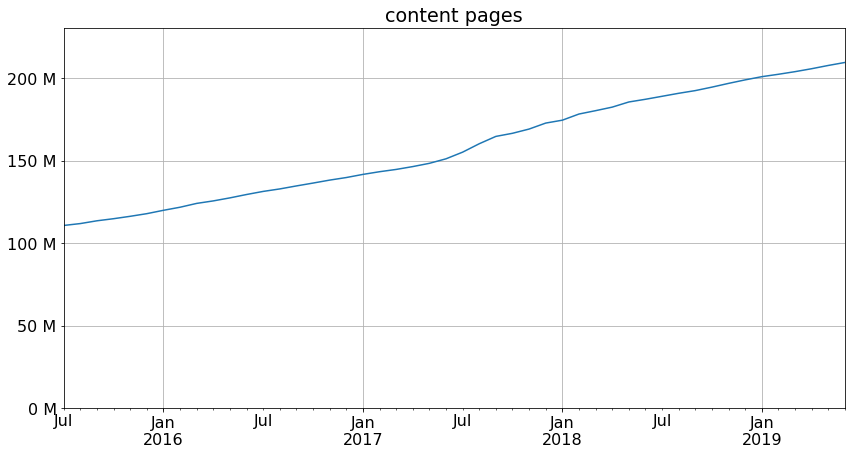

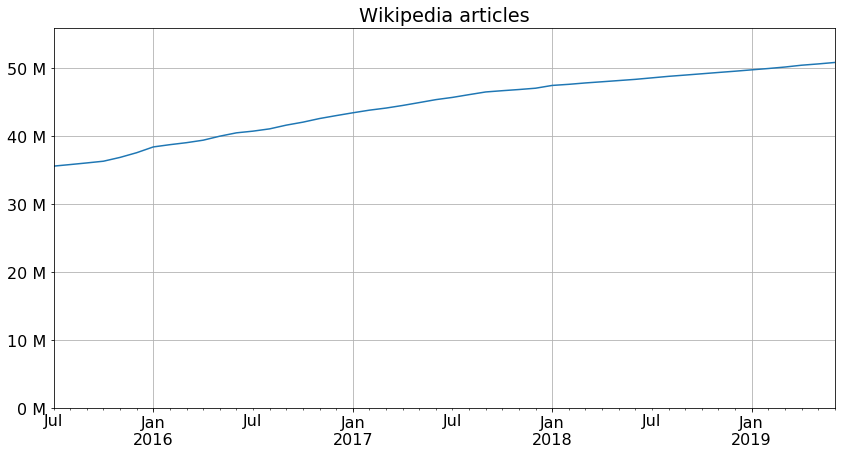

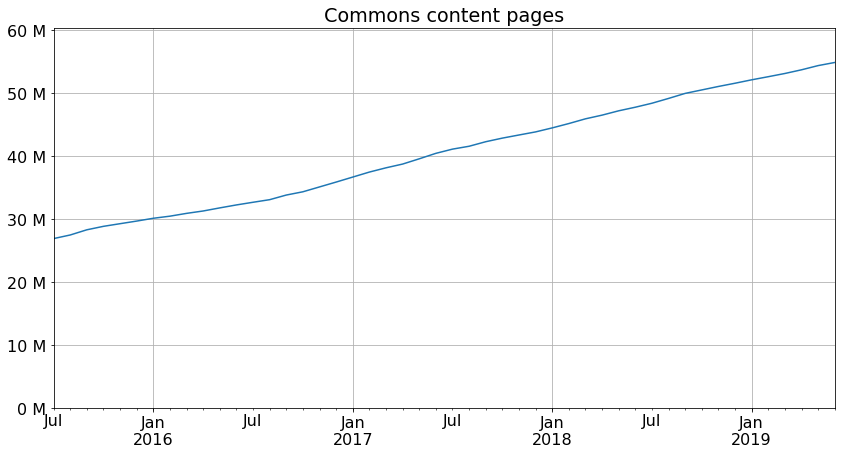

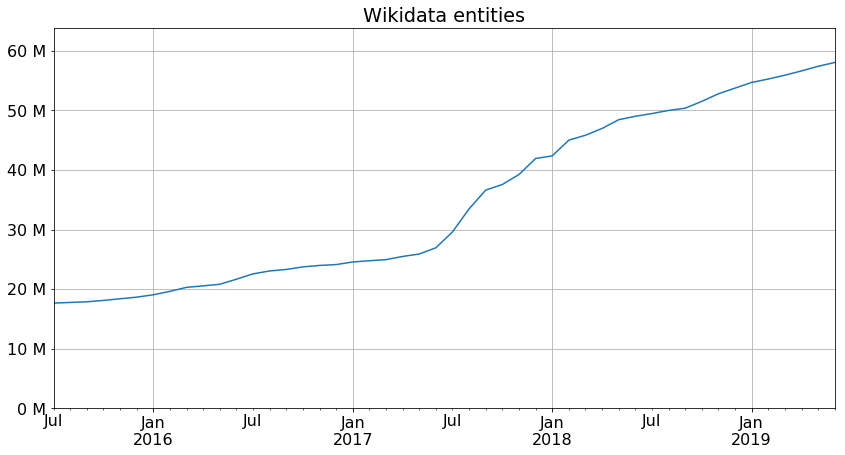

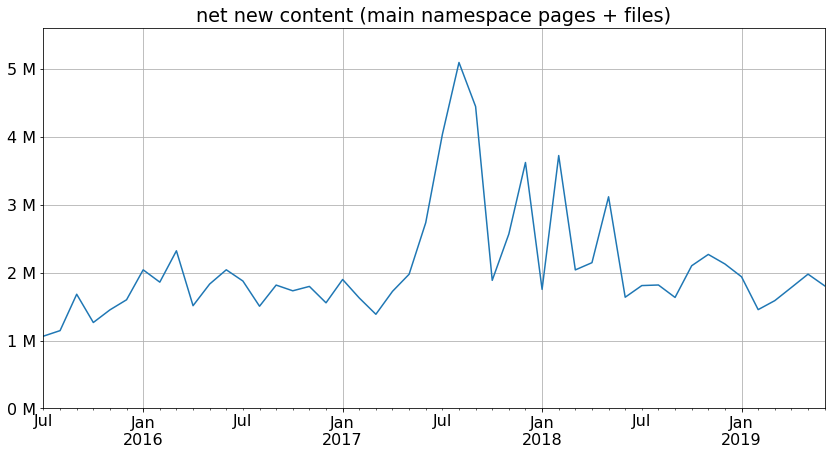

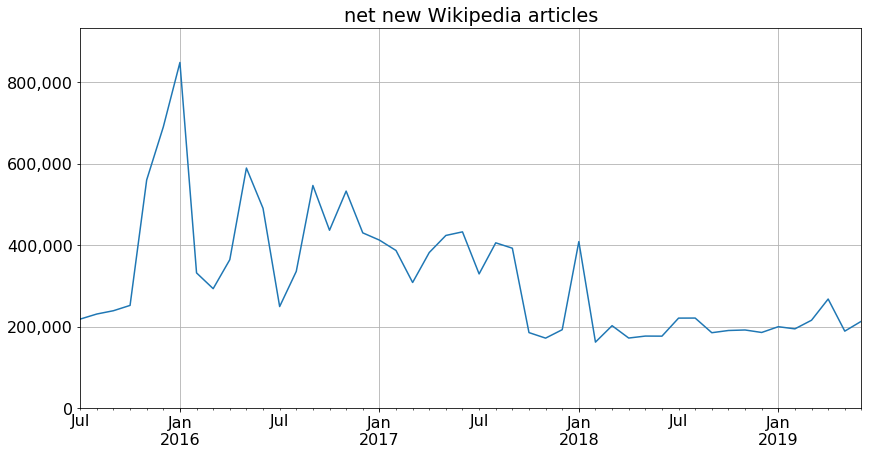

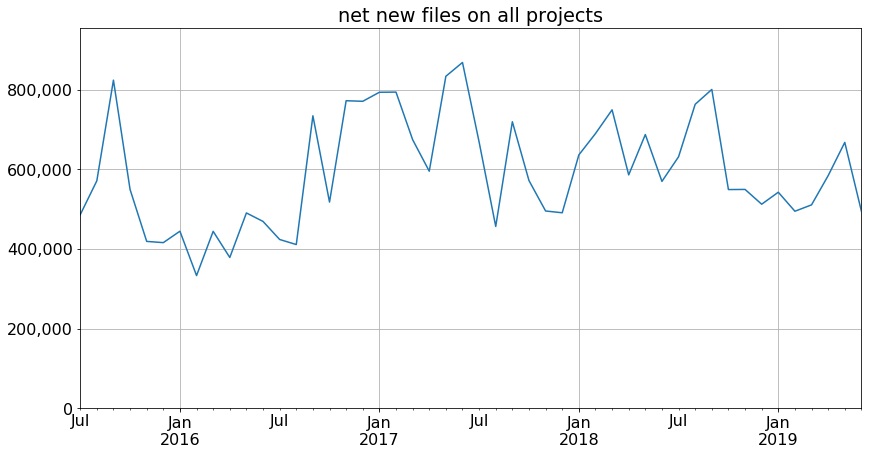

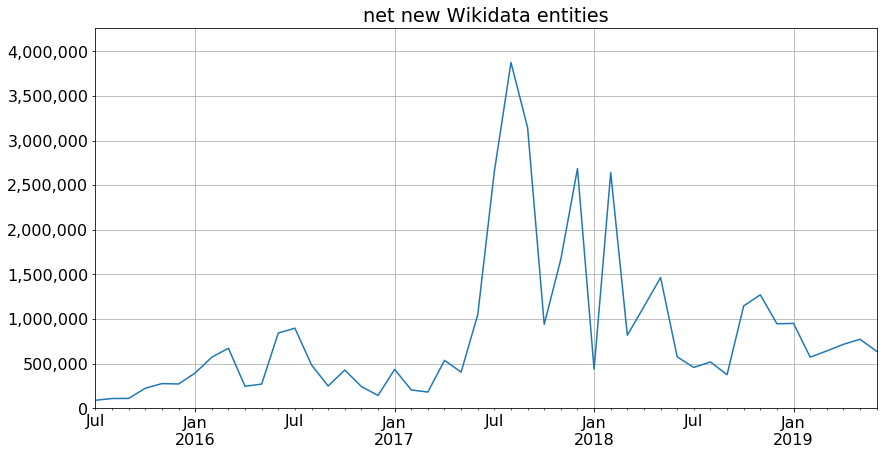

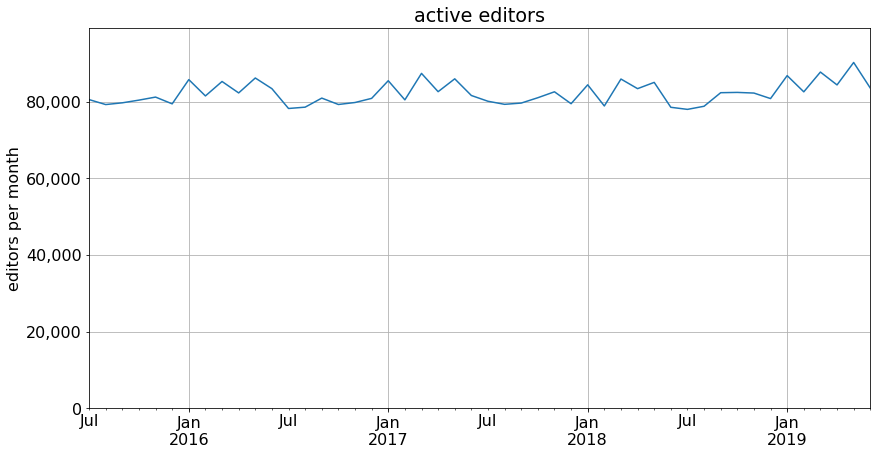

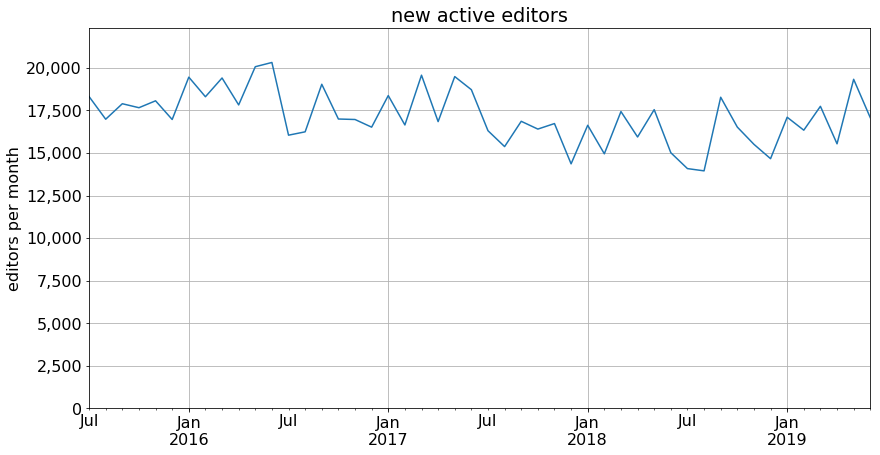

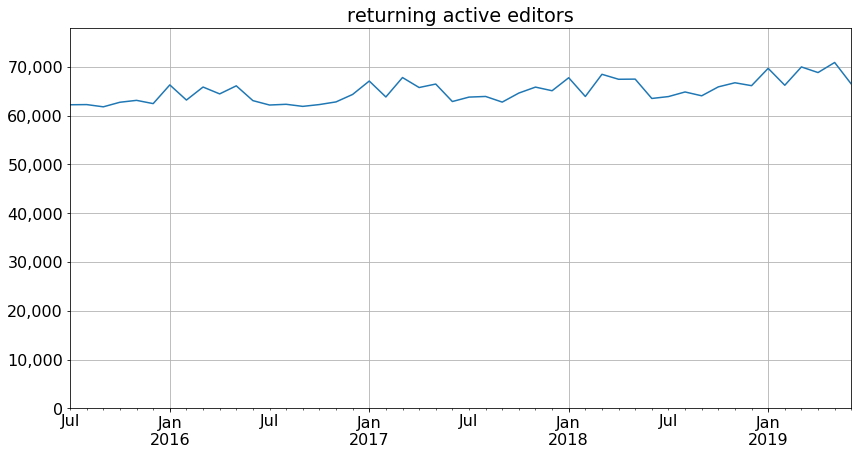

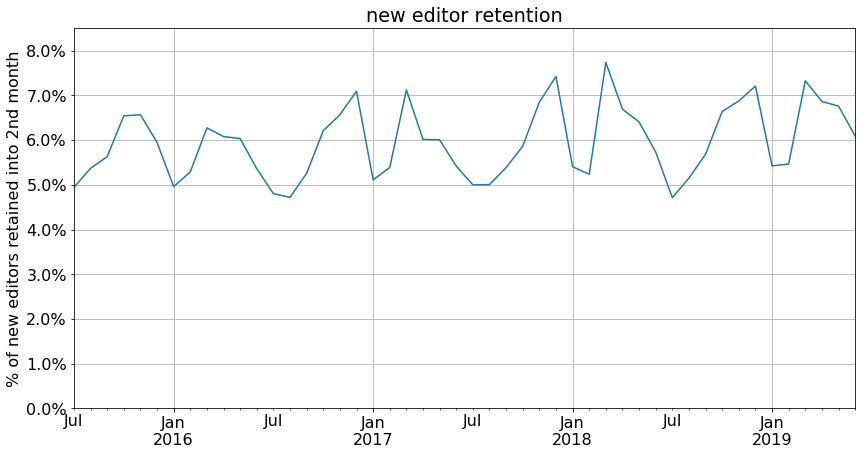

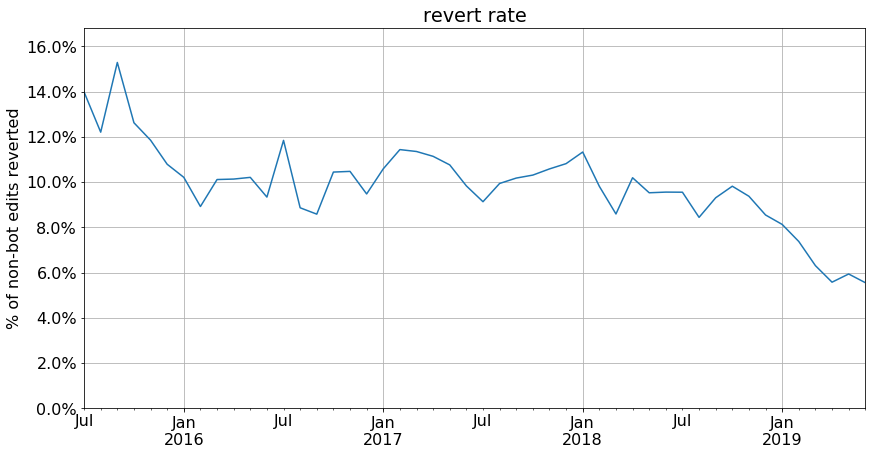

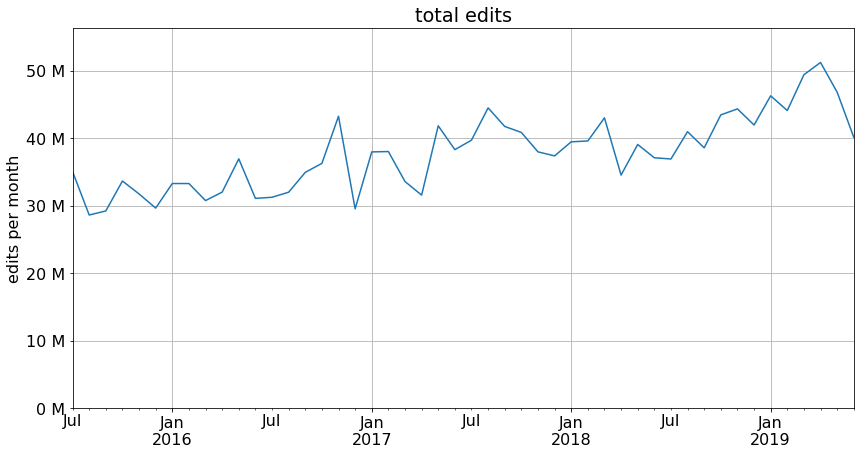

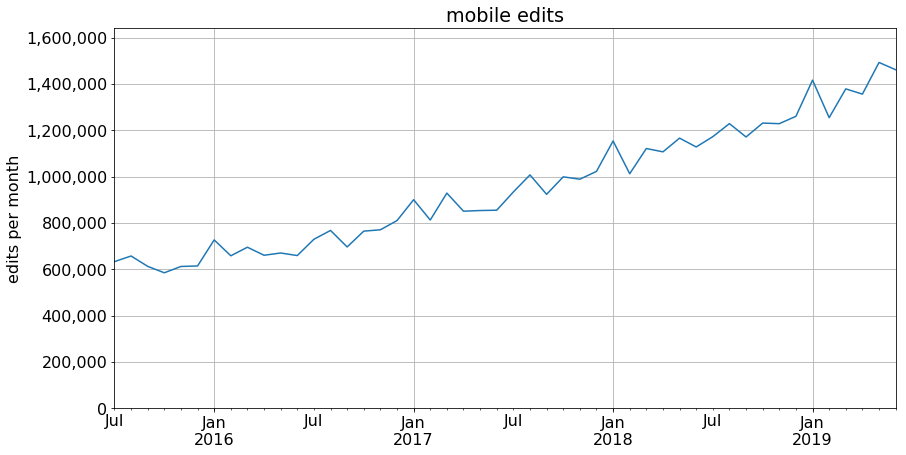

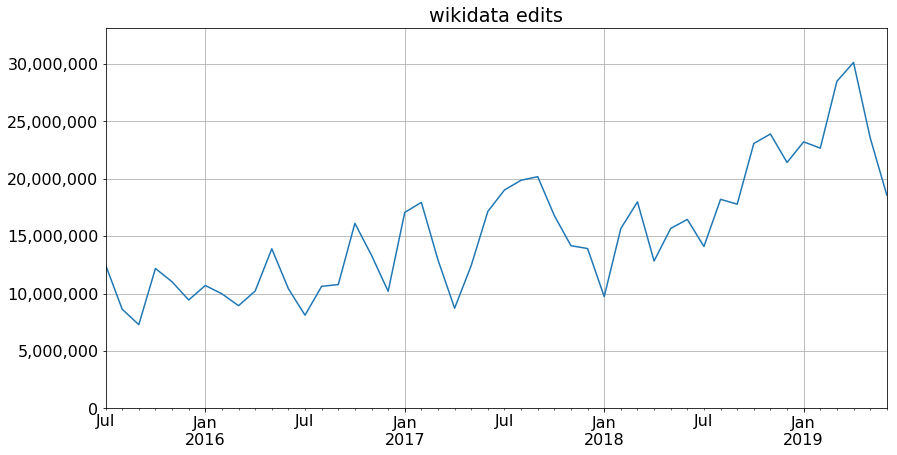

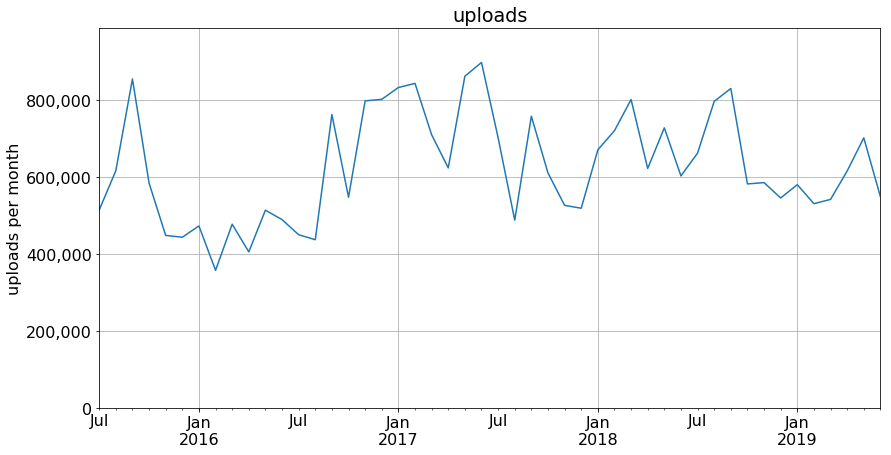

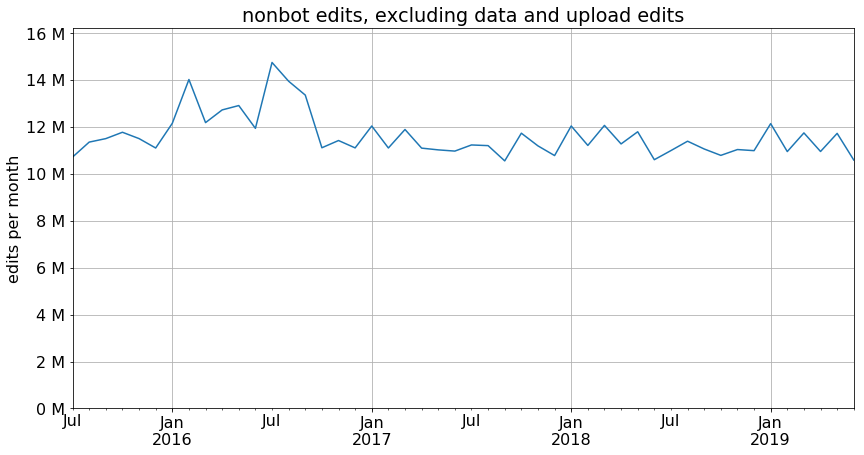

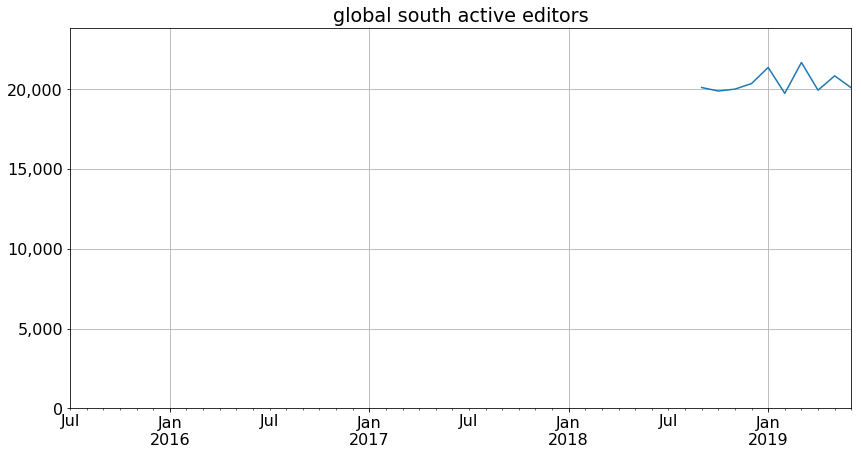

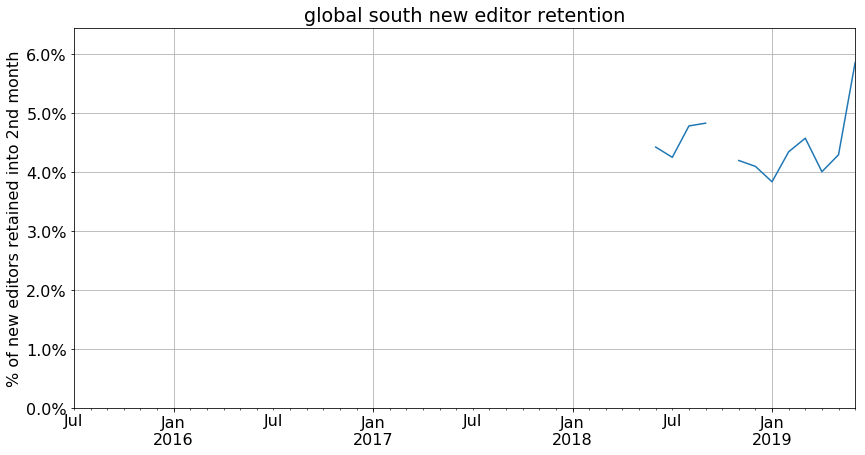

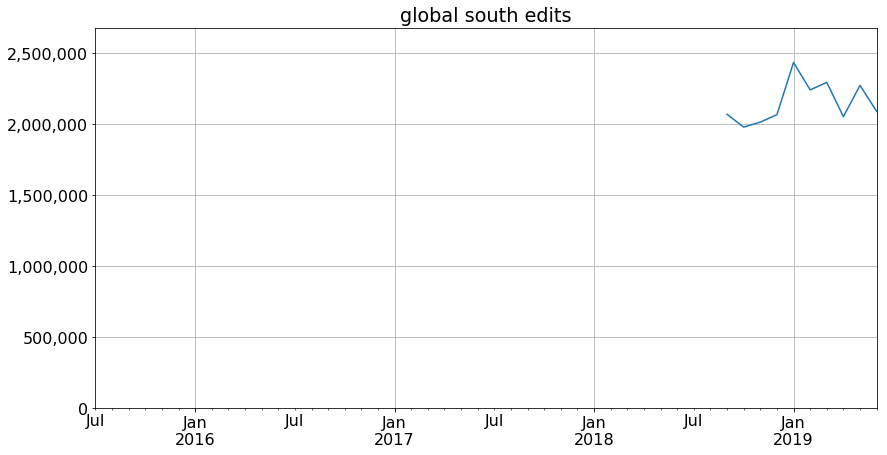

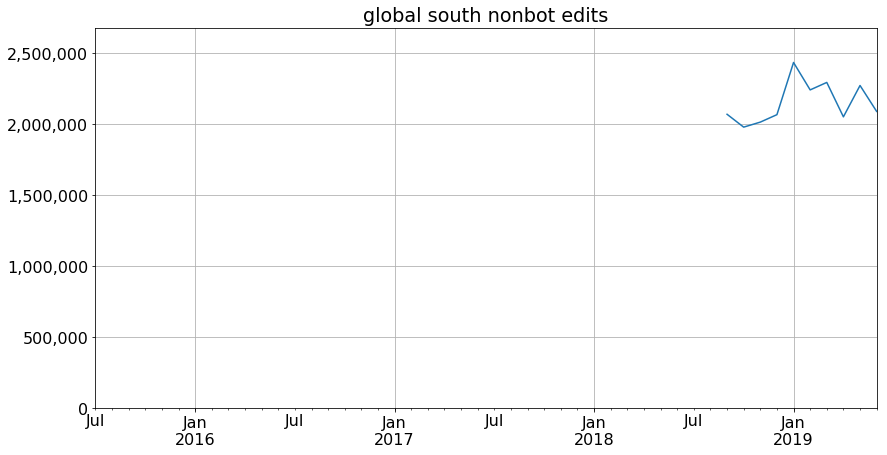

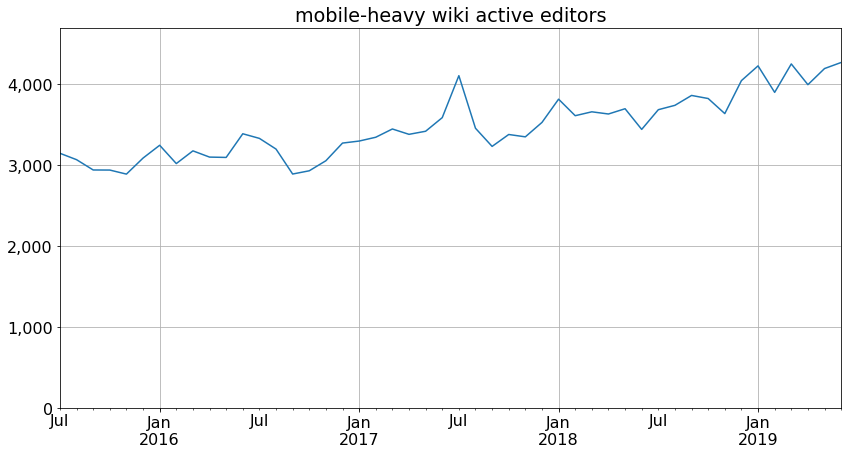

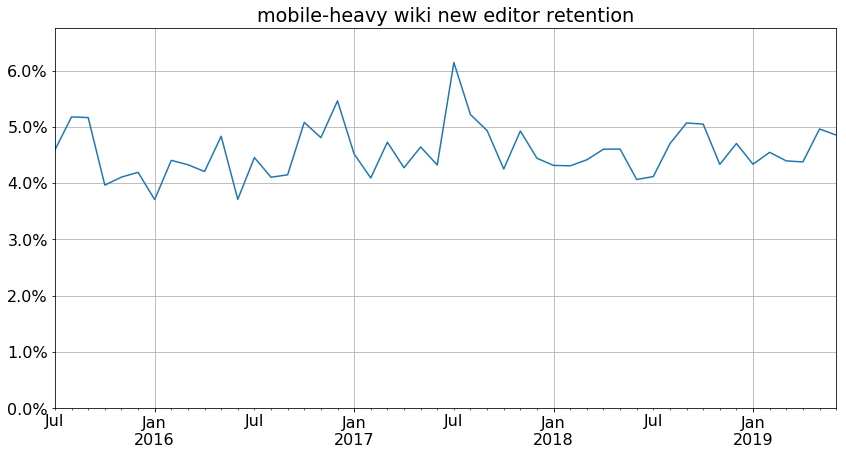

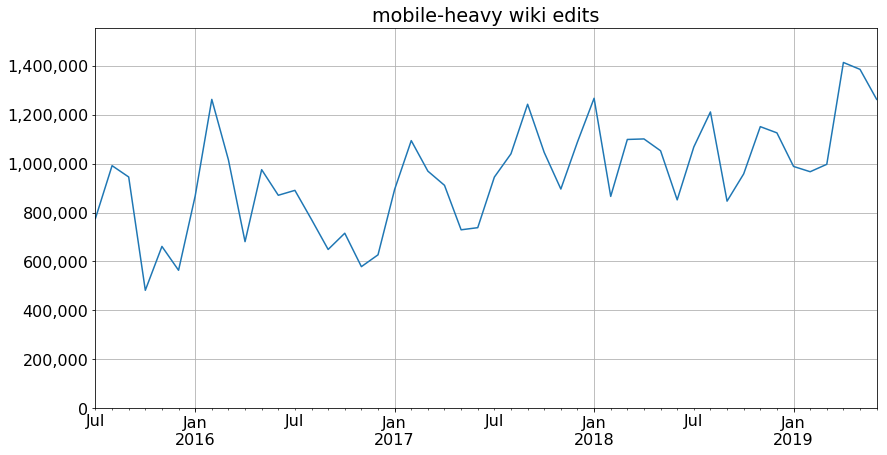

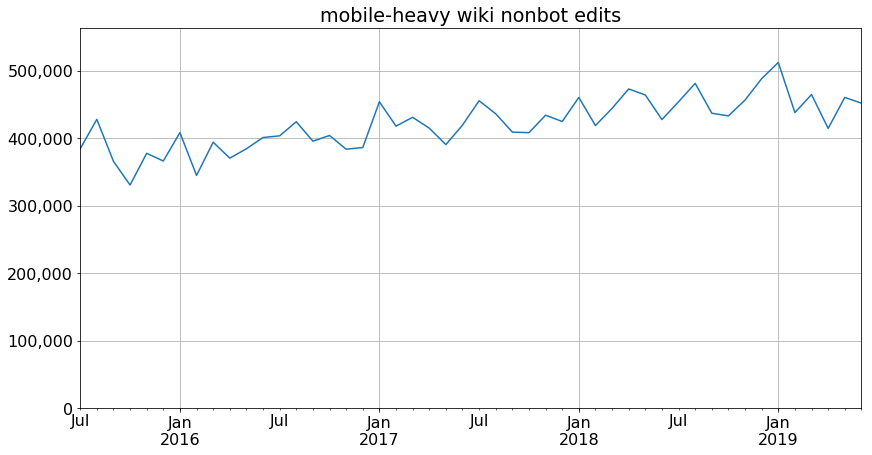

In [34]:
graph_cfg = {
    "active_editors": {
        "y_lab": "editors per month"
    },
    "content_pages": {
        "y_fmt": M_fmt,
    },
    "Wikipedia_articles": {
        "y_fmt": M_fmt,
    },
    "Wikidata_entities": {
        "y_fmt": M_fmt,
    },
    "Commons_content_pages": {
        "y_fmt": M_fmt,
    },
    "existing_active_editors": {
        "y_lab": "editors per month"
    },
    "new_active_editors": {
        "y_lab": "editors per month"
    },
    "second_month_active_editors": {
        "y_lab": "editors per month"
    },
    "total_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "mobile-heavy_wiki_new_editor_retention": {
        "y_fmt": pct_fmt
    },
    "mobile_edits": {
        "y_lab": "edits per month"
    },
    "other_nonbot_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month",
        "title": "nonbot edits, excluding data and upload edits"
    },
    "new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    },
    "revert_rate": {
        "y_fmt": pct_fmt,
        "y_lab": "% of non-bot edits reverted"
    },
    "uploads": {
        "y_lab": "uploads per month"
    },
    "data_edits": {
        "y_fmt": M_fmt,
        "y_lab": "edits per month"
    },
    "net_new_content_pages": {
        "y_fmt": M_fmt,
        "title": "net new content (main namespace pages + files)"
    },
    "net_new_Wikipedia_articles": {
    },
    "net_new_Commons_content_pages": {
        "title": "net new files on all projects"
    },
    "net_new_Wikidata_entities": {
    },
    "global_south_new_editor_retention": {
        "y_fmt": pct_fmt,
        "y_lab": "% of new editors retained into 2nd month"
    }
}

for name, col in metrics.reindex(report_order, axis=1).iteritems():
    cfg = graph_cfg.get(name, {})
    plt.figure()
    
    col[graph_start:graph_end].plot()

    plt.title(cfg.get("title", name.replace("_", " ")))
    plt.ylabel(cfg.get("y_lab", ""))
    plt.xlabel("")
    plt.gca().yaxis.set_major_formatter(cfg.get("y_fmt", comma_fmt))
    
    y_top = plt.ylim()[1] * 1.1
    plt.ylim(bottom=0, top=y_top)
    plt.show()
    plt.close()